#   Configurando o Collab 

Para utilizar este notebook no Google Drive, é necessario importar o drive e montar o diretorio pelo menos uma vez para ter acesso aos arquivos do drive compartilhado.

Observe que apos o comando "cd" estaremos na raiz do diretorio compartilhado. 

In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/Shared\ drives/cd2019-trabalho

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shared drives/cd2019-trabalho


# Load data

In [0]:
import numpy as np
import pandas as pd
import librosa
from matplotlib import pyplot as plt
from IPython.display import display, Audio
import sklearn
import pickle

In [0]:
plt.rcParams['font.size'] = 4
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['figure.dpi'] = 300

In [0]:
features = pd.read_csv('fma_metadata/features.csv', header=[0, 1, 2], index_col=0)
tracks = pd.read_csv('fma_metadata/tracks.csv', header=[0, 1], index_col=0)

In [0]:
features = features[tracks.set.subset == 'small']
tracks = tracks[tracks.set.subset == 'small']

In [0]:
print(features.columns.get_level_values('feature').unique())

Index(['chroma_cens', 'chroma_cqt', 'chroma_stft', 'mfcc', 'rmse',
       'spectral_bandwidth', 'spectral_centroid', 'spectral_contrast',
       'spectral_rolloff', 'tonnetz', 'zcr'],
      dtype='object', name='feature')


In [0]:
labels = tracks.track.genre_top
labels_1h = pd.get_dummies(labels)  # One-hot encode
features = features.sub(features.mean()).div(features.std())

In [0]:
display(features)
display(labels.unique())
(tracks.set.split == 'training').sum()/len(tracks)

feature    chroma_cens                      ...       zcr                    
statistics    kurtosis                      ...       min      skew       std
number              01        02        03  ...        01        01        01
track_id                                    ...                              
2             4.267548  2.700242  0.008039  ... -0.533763 -0.482451  0.814345
5             0.250897 -0.043857 -0.079045  ... -0.533763 -0.447538  0.173108
10            2.167539 -0.154252  0.328665  ... -0.533763  0.007833  0.016152
140           0.254529 -0.326246 -0.211844  ... -0.117259 -0.126634  0.669933
141           0.036776 -0.150949 -0.225584  ...  0.090993  0.231219 -0.452977
...                ...       ...       ...  ...       ...       ...       ...
154308       -0.476759 -0.433118 -0.145974  ... -0.117259  1.150820  1.697661
154309       -0.420824 -0.332031 -0.065072  ...  1.340505 -0.026285  3.444307
154413       -0.197112 -0.588139  0.085291  ... -0.325511  0.073428 -0.640236
154414       -0.361846 -0.481272 -0.079619  ...  0.195119  0.161330  0.206847
155066       -0.040913 -0.159033 -0.068740  ... -0.533763  2.082561 -0.370947

[8000 rows x 518 columns]

array(['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International',
       'Electronic', 'Instrumental'], dtype=object)

0.8

## Split sets

In [0]:
train = tracks.set.split == 'training'
test = tracks.set.split == 'test'
val = tracks.set.split == 'validation'

train_features = features.loc[train]
test_features = features[test]
val_features = features[val]

train_labels = labels[train]
test_labels = labels[test]
val_labels = labels[val]

# Build models

##Forest Test

In [0]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=5000, verbose=2)

In [0]:
forest.fit(train_features, train_labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 5000
building tree 2 of 5000
building tree 3 of 5000
building tree 4 of 5000
building tree 5 of 5000
building tree 6 of 5000
building tree 7 of 5000
building tree 8 of 5000
building tree 9 of 5000
building tree 10 of 5000
building tree 11 of 5000
building tree 12 of 5000
building tree 13 of 5000
building tree 14 of 5000
building tree 15 of 5000
building tree 16 of 5000
building tree 17 of 5000
building tree 18 of 5000
building tree 19 of 5000
building tree 20 of 5000
building tree 21 of 5000
building tree 22 of 5000
building tree 23 of 5000
building tree 24 of 5000
building tree 25 of 5000
building tree 26 of 5000
building tree 27 of 5000
building tree 28 of 5000
building tree 29 of 5000
building tree 30 of 5000
building tree 31 of 5000
building tree 32 of 5000
building tree 33 of 5000
building tree 34 of 5000
building tree 35 of 5000
building tree 36 of 5000
building tree 37 of 5000
building tree 38 of 5000
building tree 39 of 5000
building tree 40 of 5000
building 

[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:  8.9min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=2, warm_start=False)

In [0]:
pickle.dump(forest, open('models/forest5000.pickle', 'wb'))

In [0]:
predictions = forest.predict(test_features)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:    1.8s finished


In [0]:
for p, l, ind in zip(predictions, test_labels.values, test_labels.index):
  print(ind, p, l)

print('Acc.:', (predictions == test_labels).sum() / len(predictions))

182 Rock Rock
704 Hip-Hop International
705 Electronic International
706 Hip-Hop International
707 Pop International
708 Electronic International
709 International International
890 Experimental Folk
892 Instrumental Folk
1066 Experimental Experimental
1069 Experimental Experimental
1073 Rock Experimental
1075 Electronic Experimental
1249 Experimental Experimental
1259 Rock Experimental
3624 Rock Rock
4108 International Rock
7373 Hip-Hop Experimental
7374 Pop Experimental
7375 Electronic Experimental
7376 Folk Experimental
7377 Electronic Experimental
7378 Electronic Experimental
7379 Electronic Experimental
7381 Instrumental Experimental
7383 Hip-Hop Experimental
7385 International Experimental
7386 Electronic Experimental
7388 Instrumental Experimental
7391 Electronic Experimental
7393 Experimental Experimental
9155 Experimental Experimental
10250 Experimental Instrumental
10381 Experimental Folk
10382 Experimental Folk
10383 Folk Folk
10384 Experimental Folk
10385 Instrumental Folk


<BarContainer object of 518 artists>

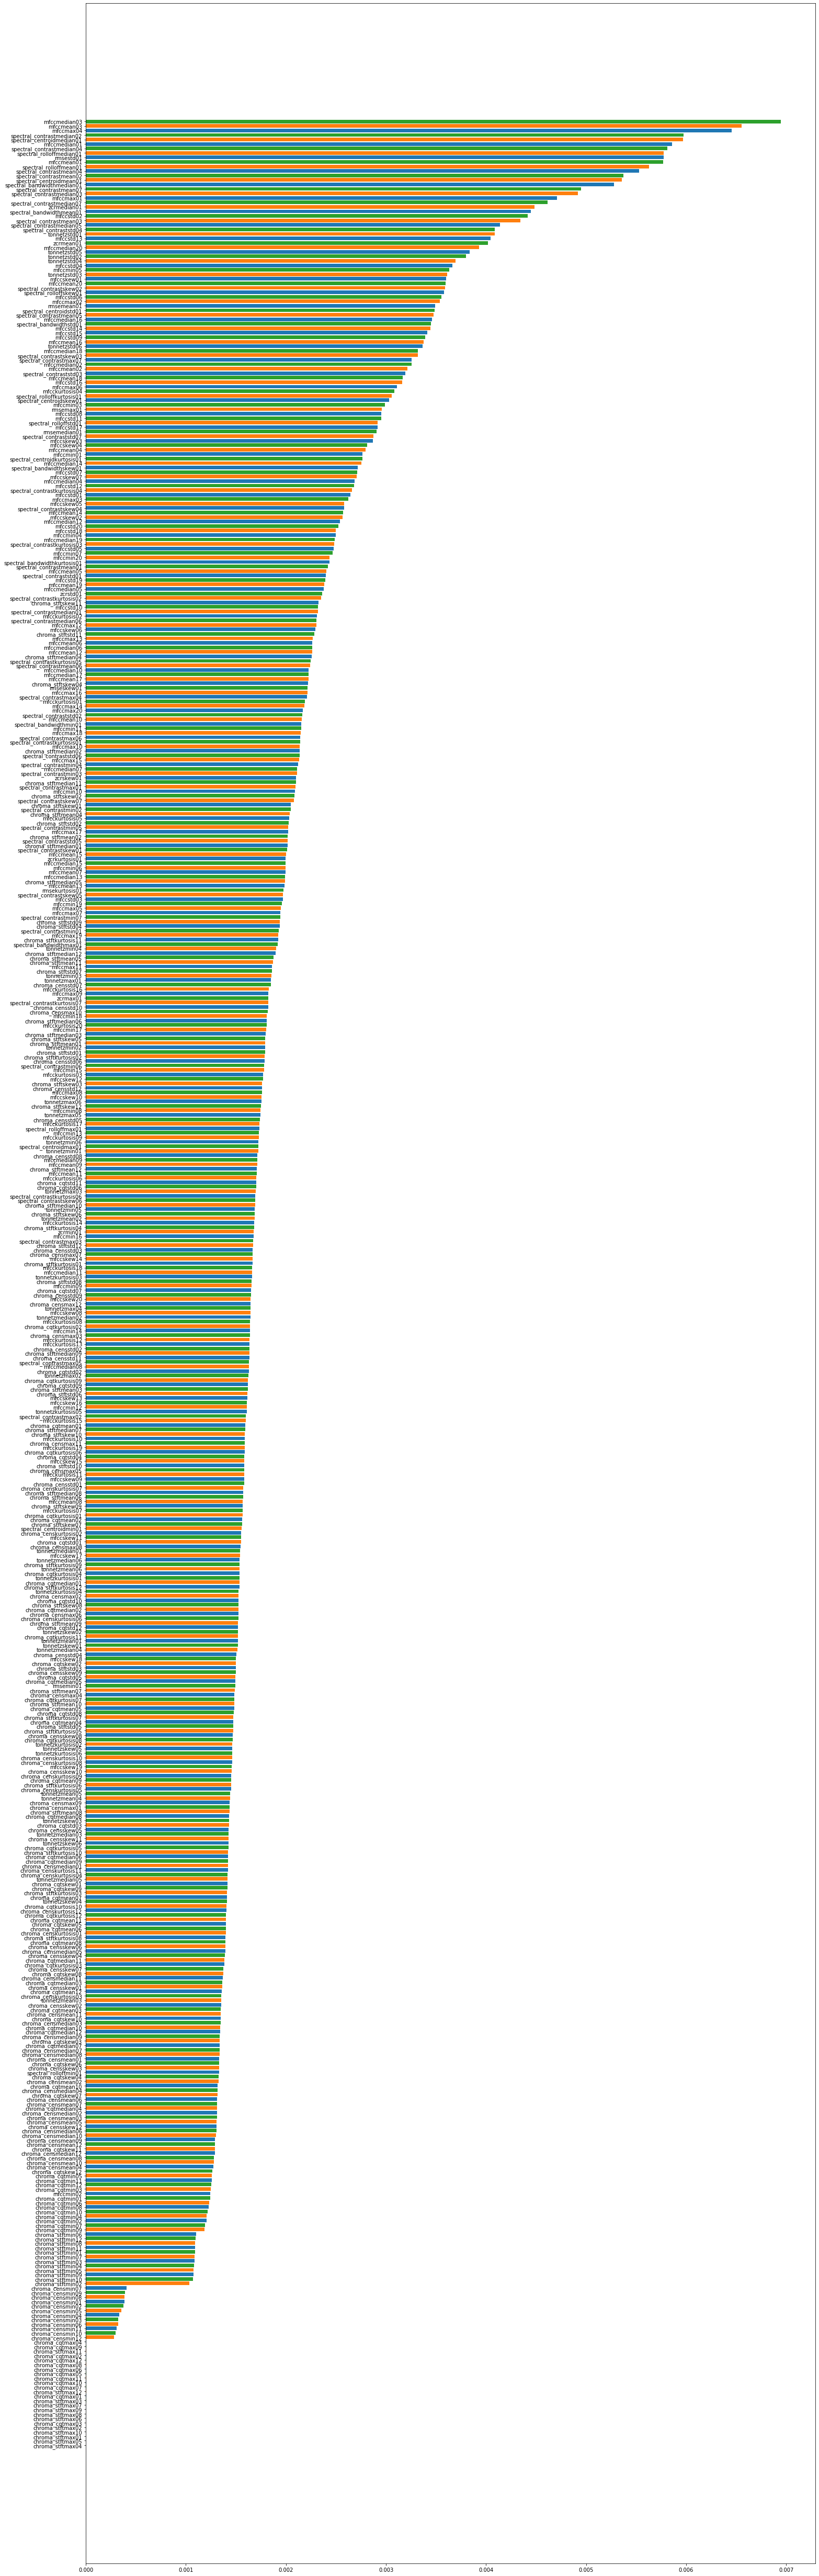

In [0]:
plt.figure(figsize=(25,90))
imps = zip(*sorted(zip(forest.feature_importances_, [''.join(i) for i in features.columns])))
plt.barh(*list(imps)[::-1], color=('C1', 'C2', 'C0'))

In [0]:
from seaborn import heatmap

genres = sorted(val_labels.unique())
print(genres)
forest_predictions = forest.predict(val_features.values)
conf_mat = sklearn.metrics.confusion_matrix(val_labels.values,
                                            forest_predictions,
                                            labels=genres)

['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:    1.7s finished


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text yticklabel objects>)

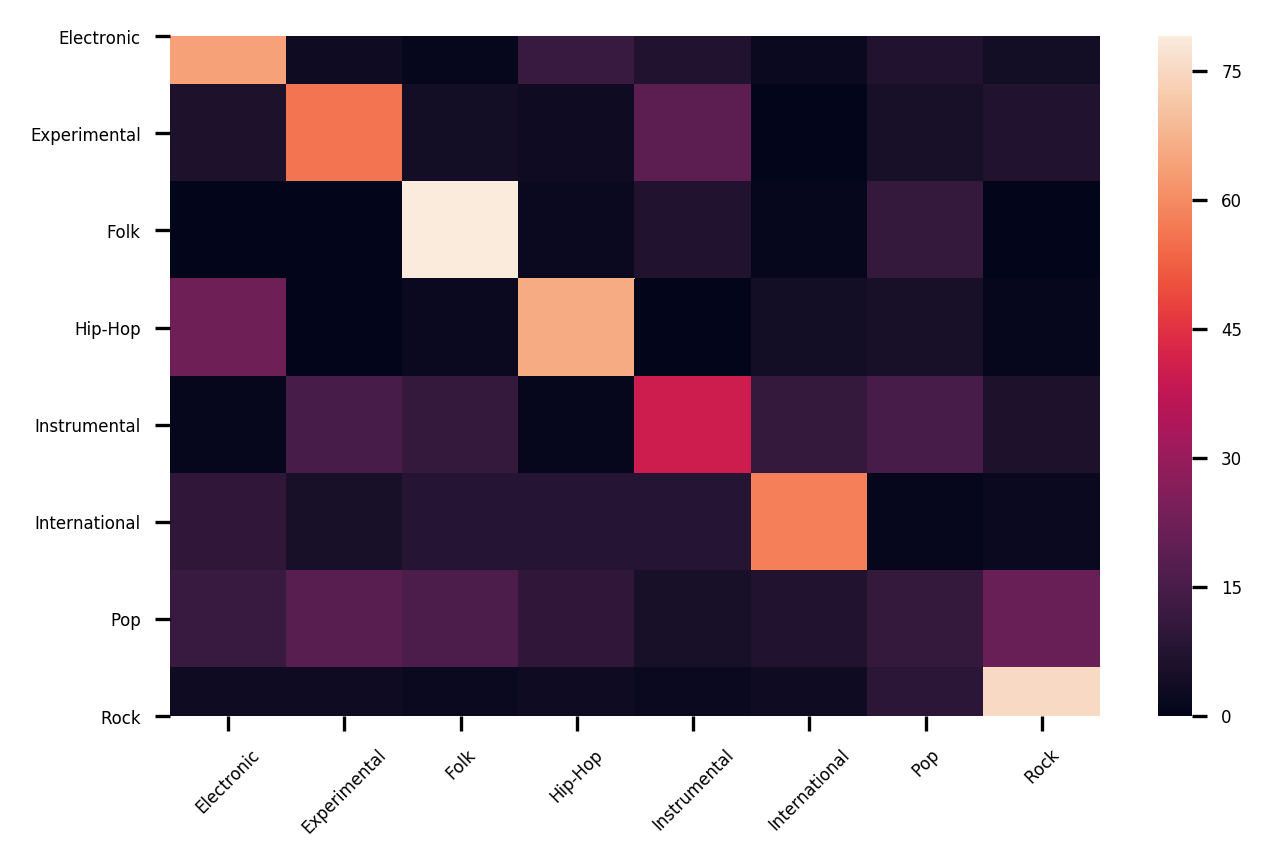

In [0]:
plt.figure(figsize=(5,3))
ax = heatmap(conf_mat)
ax.set_xticklabels(genres)
ax.set_yticklabels(genres)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

[[ 0  3  1 12  7  2  7  4]
 [ 6  0  4  3 19  0  5  7]
 [ 0  0  0  2  7  1 11  0]
 [22  0  2  0  0  4  5  1]
 [ 1 15 11  1  0 11 15  6]
 [10  5  8  8  8  0  1  2]
 [12 18 16 10  5  7  0 21]
 [ 3  3  2  3  2  3  9  0]]


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text yticklabel objects>)

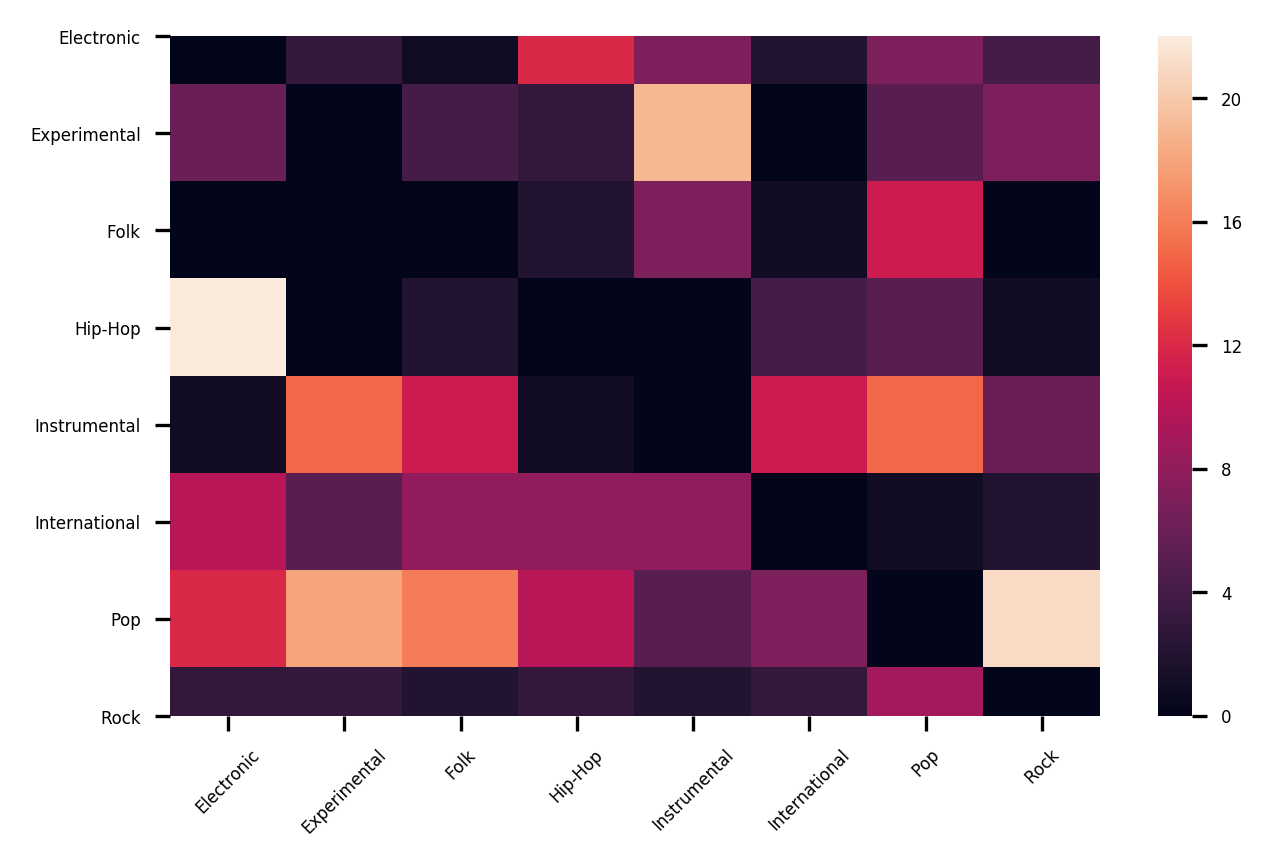

In [0]:
conf_mat_nodiag = np.copy(conf_mat)
np.fill_diagonal(conf_mat_nodiag, 0)
print(conf_mat_nodiag)
plt.figure(figsize=(5,3))
ax = heatmap(conf_mat_nodiag)
ax.set_xticklabels(genres)
ax.set_yticklabels(genres)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

In [0]:
print(conf_mat.diagonal().sum()/conf_mat.sum())
print(conf_mat.sum())

0.56125
800


## Compare classifiers

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

![sklearn classifiers comparison.](https://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png)

In [0]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.smv import SVC

In [0]:
verbose = 0

classifiers = {
    "Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(kernel="linear", verbose=True, gamma='auto', tol=0.1),
    "RBF SVM": SVC(verbose=True, gamma='auto', tol=0.1),
    "Decision Tree": DecisionTreeClassifier(max_depth=10),
    "Random Forest": RandomForestClassifier(max_depth=10, n_estimators=1000, max_features=4, verbose=True, n_jobs=-1),
    "MLP": MLPClassifier(alpha=0.001, max_iter=1000, verbose=True, solver='lbfgs', hidden_layer_sizes=(16,)),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(),
    "QDA": QuadraticDiscriminantAnalysis(),
}
    # "Gaussian Process": GaussianProcessClassifier(kernel=1.0*RBF(1.0), max_iter_predict=25, n_jobs=-1),

### 1 descritor por vez


=================== CHROMA_CENS ====================

Training Nearest Neighbors Classifier
Acc.: 0.22625
Training Linear SVM Classifier
[LibSVM]Acc.: 0.26625
Training RBF SVM Classifier
[LibSVM]Acc.: 0.32
Training Decision Tree Classifier
Acc.: 0.18375
Training Random Forest Classifier


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   12.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished


Acc.: 0.275
Training MLP Classifier
Acc.: 0.2975
Training AdaBoost Classifier
Acc.: 0.2275
Training Naive Bayes Classifier
Acc.: 0.18625
Training QDA Classifier
Acc.: 0.2375


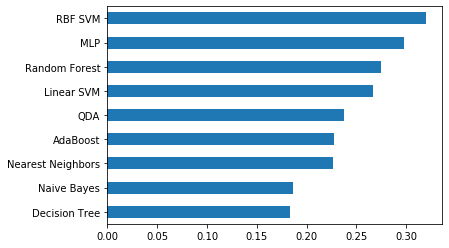


==================== CHROMA_CQT ====================

Training Nearest Neighbors Classifier
Acc.: 0.23375
Training Linear SVM Classifier
[LibSVM]Acc.: 0.28375
Training RBF SVM Classifier
[LibSVM]Acc.: 0.29625
Training Decision Tree Classifier
Acc.: 0.20375
Training Random Forest Classifier


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   11.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished


Acc.: 0.2825
Training MLP Classifier
Acc.: 0.295
Training AdaBoost Classifier
Acc.: 0.24375
Training Naive Bayes Classifier
Acc.: 0.1725
Training QDA Classifier
Acc.: 0.135


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


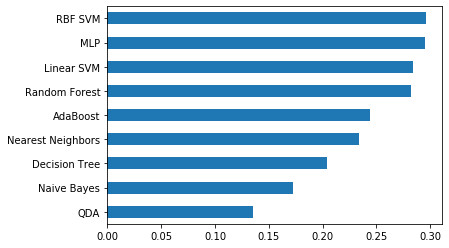


=================== CHROMA_STFT ====================

Training Nearest Neighbors Classifier
Acc.: 0.3075
Training Linear SVM Classifier
[LibSVM]Acc.: 0.33375
Training RBF SVM Classifier
[LibSVM]Acc.: 0.37375
Training Decision Tree Classifier
Acc.: 0.27875
Training Random Forest Classifier


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   11.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished


Acc.: 0.365
Training MLP Classifier
Acc.: 0.32875
Training AdaBoost Classifier
Acc.: 0.29375
Training Naive Bayes Classifier
Acc.: 0.16
Training QDA Classifier
Acc.: 0.2


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


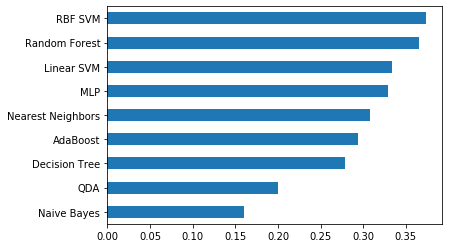


======================= MFCC =======================

Training Nearest Neighbors Classifier
Acc.: 0.37
Training Linear SVM Classifier
[LibSVM]Acc.: 0.4175
Training RBF SVM Classifier
[LibSVM]Acc.: 0.46375
Training Decision Tree Classifier
Acc.: 0.3
Training Random Forest Classifier


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   12.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished


Acc.: 0.42375
Training MLP Classifier
Acc.: 0.3975
Training AdaBoost Classifier
Acc.: 0.33375
Training Naive Bayes Classifier
Acc.: 0.36
Training QDA Classifier
Acc.: 0.395


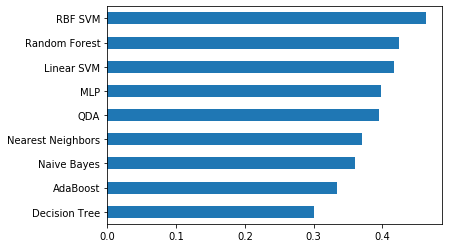


======================= RMSE =======================

Training Nearest Neighbors Classifier
Acc.: 0.2025
Training Linear SVM Classifier
[LibSVM]Acc.: 0.21875
Training RBF SVM Classifier
[LibSVM]Acc.: 0.23
Training Decision Tree Classifier
Acc.: 0.195
Training Random Forest Classifier


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   12.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished


Acc.: 0.2325
Training MLP Classifier
Acc.: 0.24375
Training AdaBoost Classifier
Acc.: 0.25125
Training Naive Bayes Classifier
Acc.: 0.195
Training QDA Classifier
Acc.: 0.1775


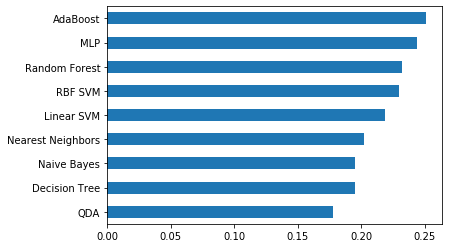


================ SPECTRAL_BANDWIDTH ================

Training Nearest Neighbors Classifier
Acc.: 0.30875
Training Linear SVM Classifier
[LibSVM]Acc.: 0.31875
Training RBF SVM Classifier
[LibSVM]Acc.: 0.31125
Training Decision Tree Classifier
Acc.: 0.22
Training Random Forest Classifier


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   12.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished


Acc.: 0.31625
Training MLP Classifier
Acc.: 0.3275
Training AdaBoost Classifier
Acc.: 0.27875
Training Naive Bayes Classifier
Acc.: 0.29
Training QDA Classifier
Acc.: 0.28


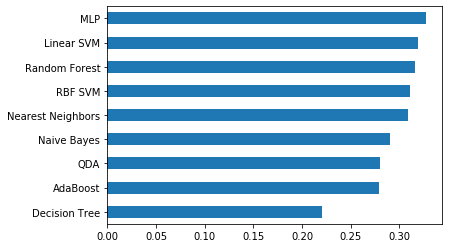


================ SPECTRAL_CENTROID =================

Training Nearest Neighbors Classifier
Acc.: 0.3025
Training Linear SVM Classifier
[LibSVM]Acc.: 0.325
Training RBF SVM Classifier
[LibSVM]Acc.: 0.32875
Training Decision Tree Classifier
Acc.: 0.26875
Training Random Forest Classifier


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   12.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished


Acc.: 0.28875
Training MLP Classifier
Acc.: 0.3375
Training AdaBoost Classifier
Acc.: 0.30625
Training Naive Bayes Classifier
Acc.: 0.2575
Training QDA Classifier
Acc.: 0.26


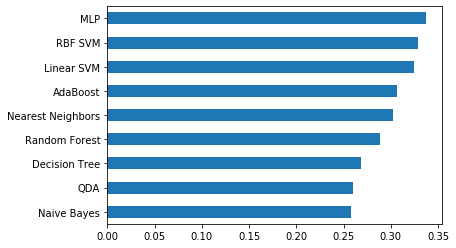


================ SPECTRAL_CONTRAST =================

Training Nearest Neighbors Classifier
Acc.: 0.34625
Training Linear SVM Classifier
[LibSVM]Acc.: 0.37125
Training RBF SVM Classifier
[LibSVM]Acc.: 0.40375
Training Decision Tree Classifier
Acc.: 0.27875
Training Random Forest Classifier


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   12.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished


Acc.: 0.3825
Training MLP Classifier
Acc.: 0.38375
Training AdaBoost Classifier
Acc.: 0.34125
Training Naive Bayes Classifier
Acc.: 0.35125
Training QDA Classifier
Acc.: 0.33875


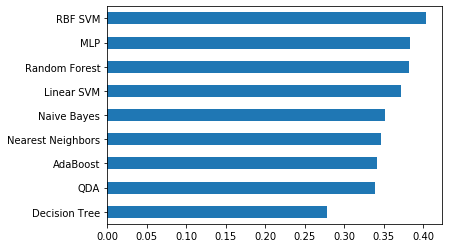


================= SPECTRAL_ROLLOFF =================

Training Nearest Neighbors Classifier
Acc.: 0.30875
Training Linear SVM Classifier
[LibSVM]Acc.: 0.315
Training RBF SVM Classifier
[LibSVM]Acc.: 0.31125
Training Decision Tree Classifier
Acc.: 0.29375
Training Random Forest Classifier


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   10.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished


Acc.: 0.31375
Training MLP Classifier
Acc.: 0.2975
Training AdaBoost Classifier
Acc.: 0.28875
Training Naive Bayes Classifier
Acc.: 0.24625
Training QDA Classifier
Acc.: 0.23875


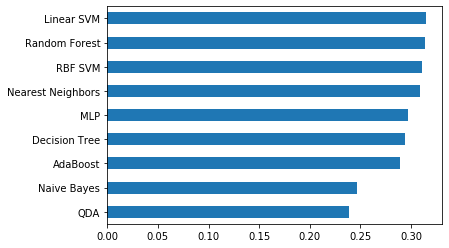


===================== TONNETZ ======================

Training Nearest Neighbors Classifier
Acc.: 0.2225
Training Linear SVM Classifier
[LibSVM]Acc.: 0.26875
Training RBF SVM Classifier
[LibSVM]Acc.: 0.27875
Training Decision Tree Classifier
Acc.: 0.20125
Training Random Forest Classifier


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   12.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished


Acc.: 0.27125
Training MLP Classifier
Acc.: 0.2925
Training AdaBoost Classifier
Acc.: 0.255
Training Naive Bayes Classifier
Acc.: 0.22875
Training QDA Classifier
Acc.: 0.225


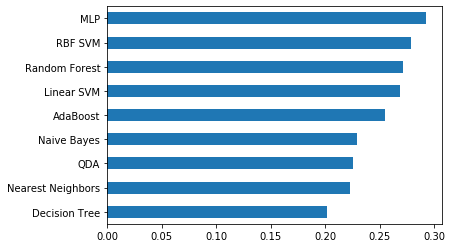


======================= ZCR ========================

Training Nearest Neighbors Classifier
Acc.: 0.2325
Training Linear SVM Classifier
[LibSVM]Acc.: 0.24875
Training RBF SVM Classifier
[LibSVM]Acc.: 0.25875
Training Decision Tree Classifier
Acc.: 0.22125
Training Random Forest Classifier


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   10.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished


Acc.: 0.24125
Training MLP Classifier
Acc.: 0.285
Training AdaBoost Classifier
Acc.: 0.255
Training Naive Bayes Classifier
Acc.: 0.23
Training QDA Classifier
Acc.: 0.2225


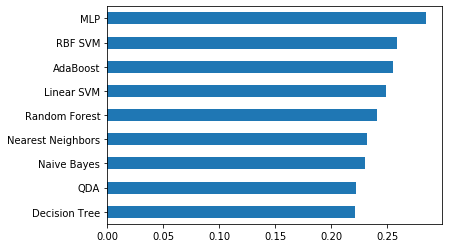

In [0]:
acc_df = pd.DataFrame()

for feature in features.columns.get_level_values(0).unique():
  
  print(f"\n{' '+feature.upper()+' ':=^52}\n")
  predictions = []
  accuracies = []
  
  for name, classifier in classifiers.items():
    print(f'Training {name} Classifier')
    classifier.fit(train_features[feature].values, train_labels.values)
    predictions.append(classifier.predict(test_features[feature].values))
    # -1 pra pegar a última predição entre as de todos os modelos
    acc = (predictions[-1] == test_labels.values).sum() / len(predictions[-1])
    accuracies.append(acc)
    print('Acc.:', acc)
  
  new_col = pd.Series(index=classifiers.keys(),
                      data=accuracies,
                      name=feature)
  acc_df = acc_df.merge(new_col, right_index=True, left_index=True, how='outer')
  new_col.sort_values().plot.barh()
  plt.show()

                      mfcc  spectral_contrast  ...  chroma_cens     rmse
Nearest Neighbors  0.34750            0.31750  ...      0.23125  0.18500
Linear SVM         0.41750            0.37125  ...      0.26625  0.21875
RBF SVM            0.46375            0.40375  ...      0.32000  0.23000
Decision Tree      0.29875            0.28125  ...      0.18750  0.20000
Random Forest      0.43250            0.38500  ...      0.26625  0.24000
MLP                0.40125            0.38875  ...      0.28625  0.23500
AdaBoost           0.33375            0.34125  ...      0.22750  0.25125
Naive Bayes        0.36000            0.35125  ...      0.18625  0.19500
QDA                0.39500            0.33875  ...      0.23750  0.17750

[9 rows x 11 columns]


,mfcc,spectral_contrast,chroma_stft,spectral_centroid,spectral_rolloff,spectral_bandwidth,tonnetz,chroma_cqt,zcr,chroma_cens,rmse
Nearest Neighbors,0.34750,0.31750,0.30000,0.26250,0.23000,0.24875,0.21000,0.20375,0.22125,0.23125,0.18500
Linear SVM,0.41750,0.37125,0.33375,0.32500,0.31500,0.31875,0.26875,0.28375,0.24875,0.26625,0.21875
RBF SVM,0.46375,0.40375,0.37375,0.32875,0.31125,0.31125,0.27875,0.29625,0.25875,0.32000,0.23000
Decision Tree,0.29875,0.28125,0.28250,0.26875,0.29000,0.21500,0.18625,0.19875,0.22750,0.18750,0.20000
Random Forest,0.43250,0.38500,0.36625,0.29500,0.31625,0.31750,0.28500,0.27375,0.24000,0.26625,0.24000
MLP,0.40125,0.38875,0.32750,0.34000,0.33750,0.29750,0.28000,0.29000,0.28250,0.28625,0.23500
AdaBoost,0.33375,0.34125,0.29375,0.30625,0.28875,0.27875,0.25500,0.24375,0.25500,0.22750,0.25125
Naive Bayes,0.36000,0.35125,0.16000,0.25750,0.24625,0.29000,0.22875,0.17250,0.23000,0.18625,0.19500
QDA,0.39500,0.33875,0.20000,0.26000,0.23875,0.28000,0.22500,0.13500,0.22250,0.23750,0.17750


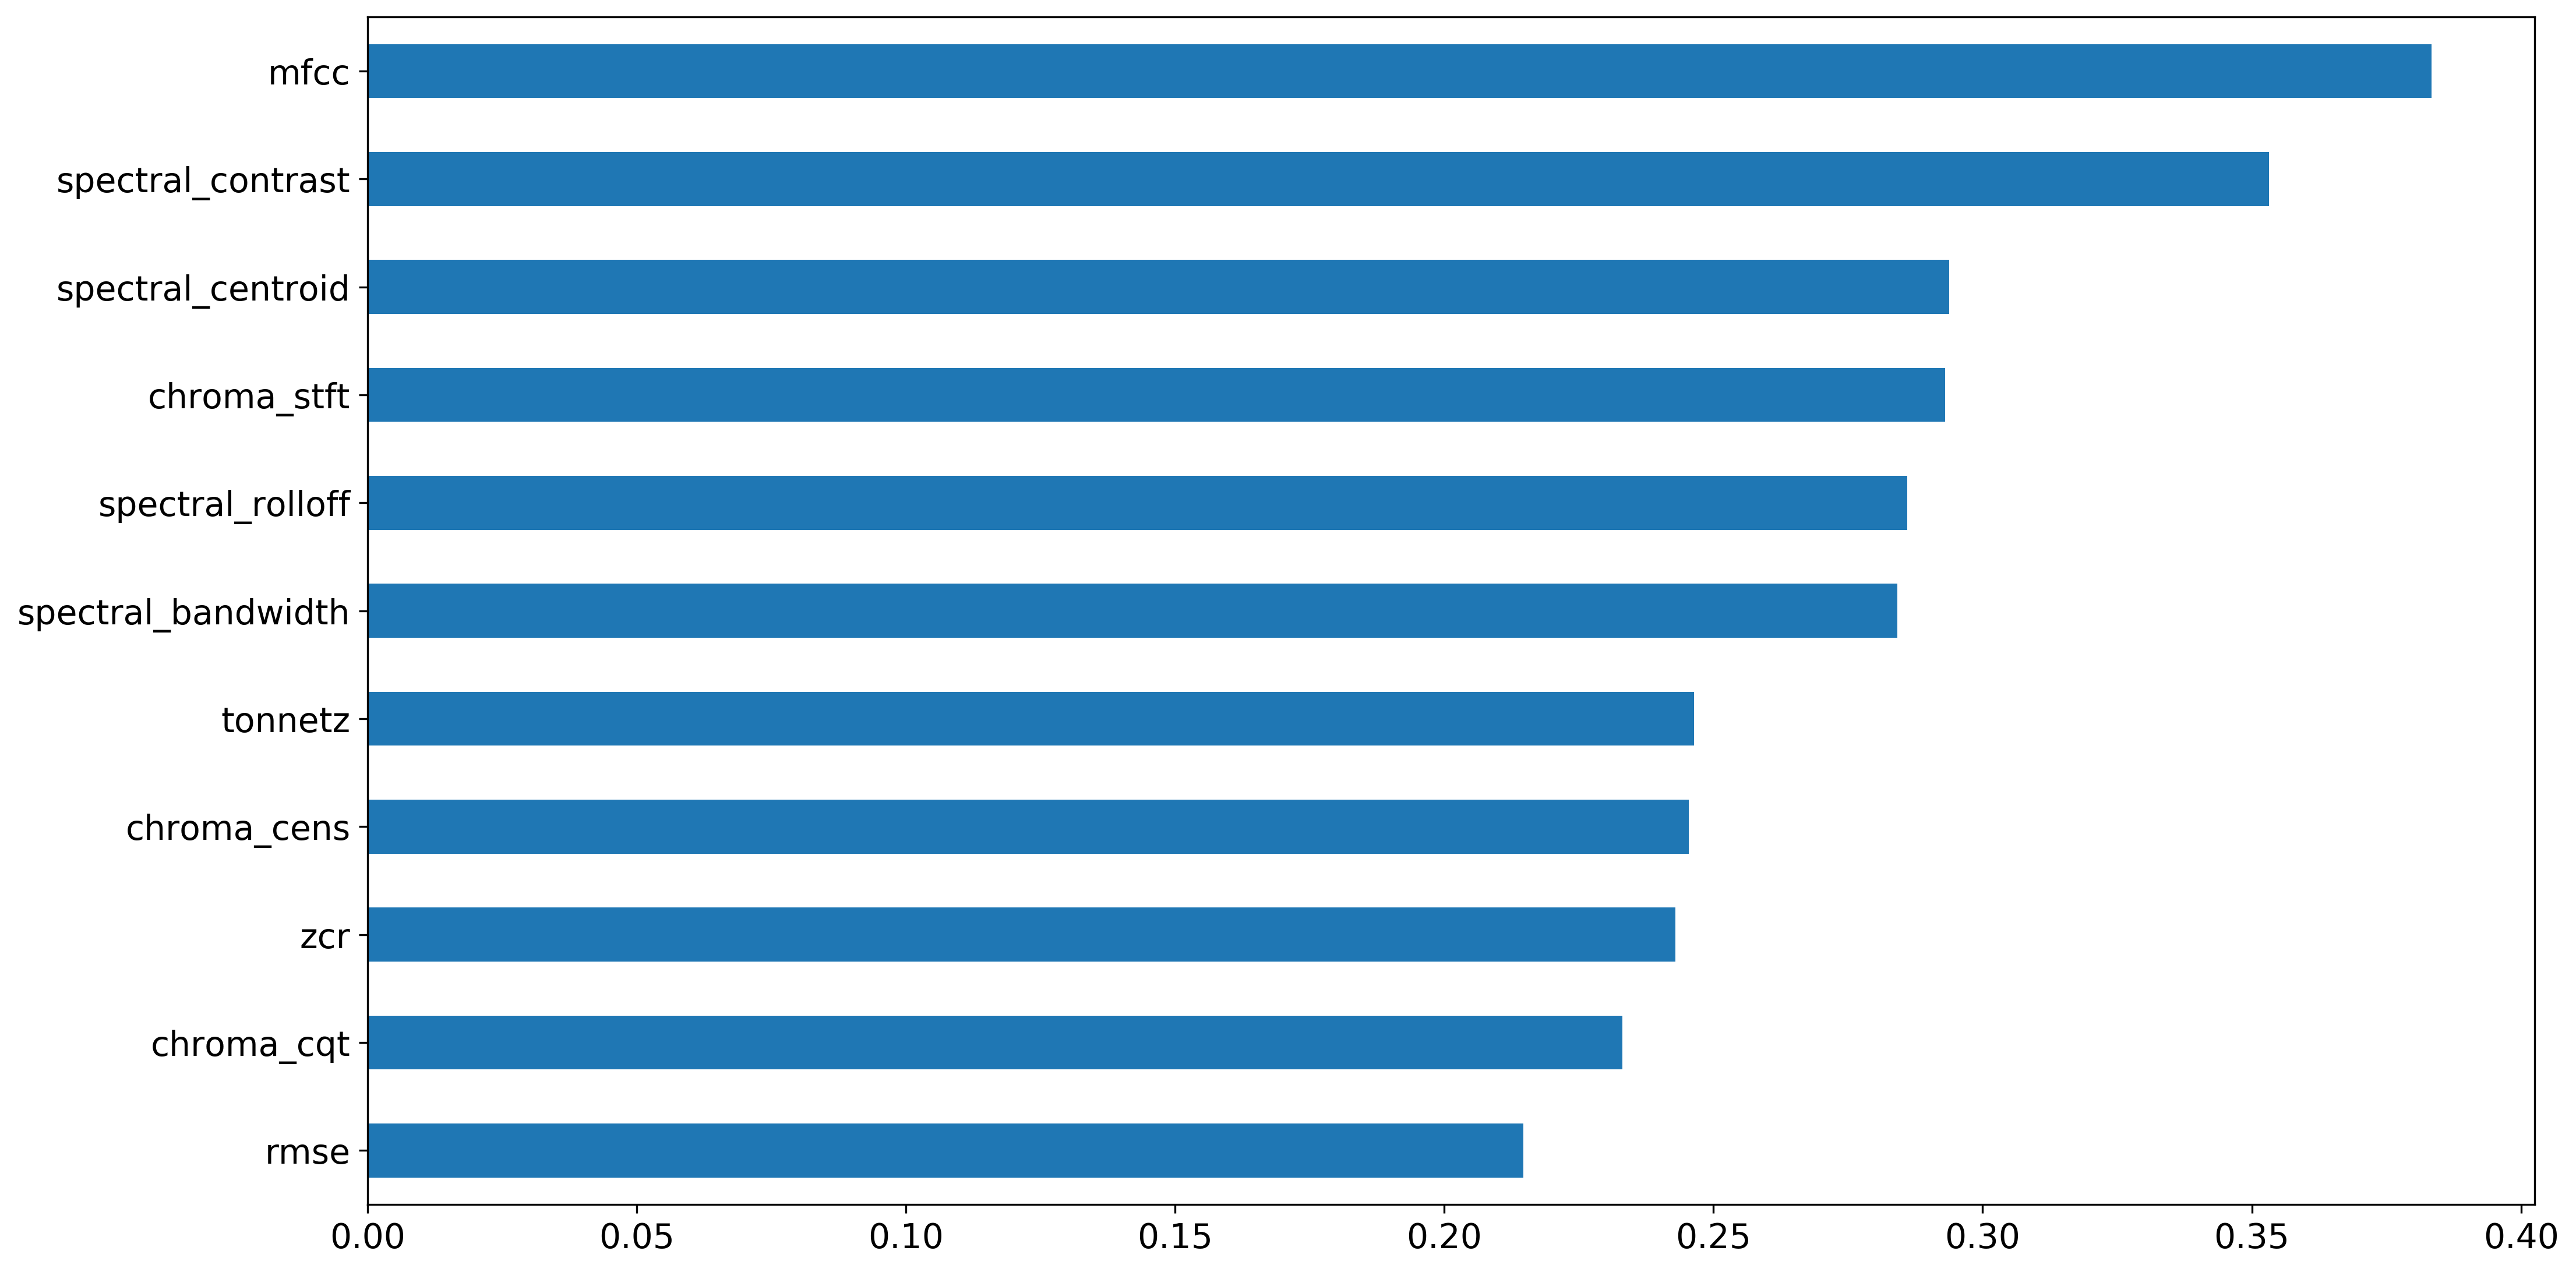

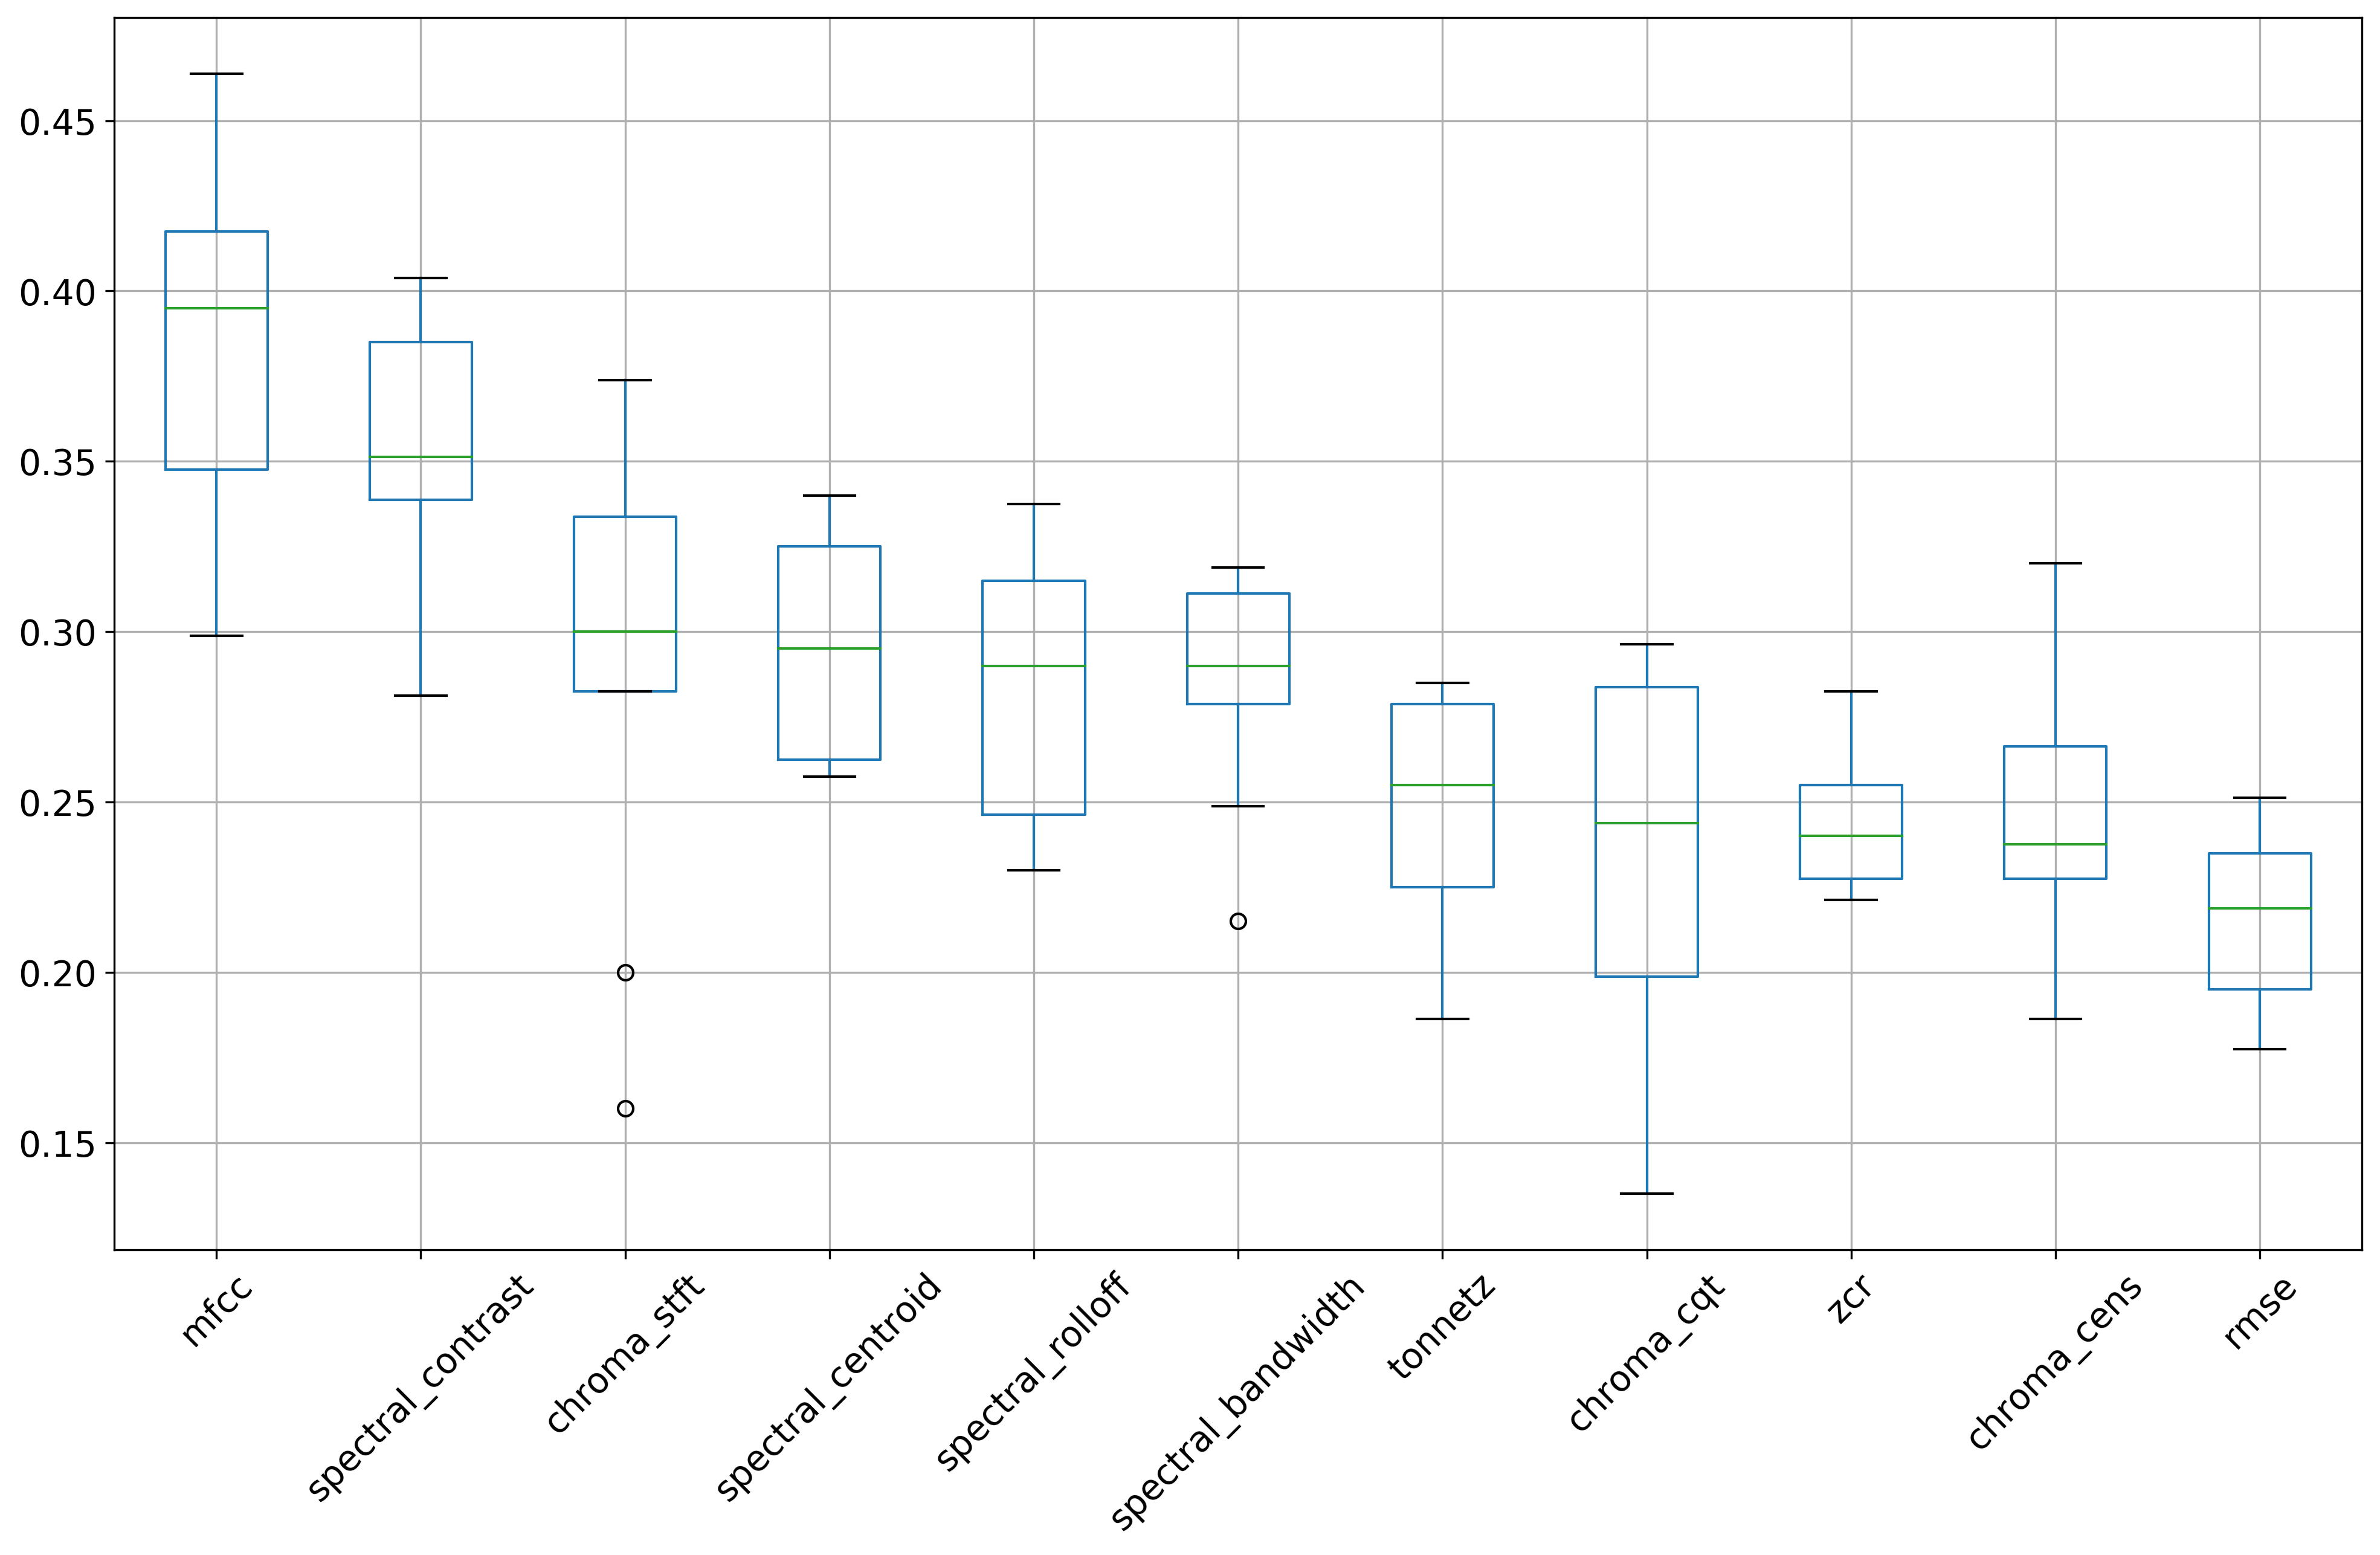

In [0]:
acc_df = acc_df[acc_df.median().sort_values(ascending=False).index]
print(acc_df)
display(acc_df)
acc_df.mean().sort_values().plot.barh()
plt.figure()
acc_df.boxplot(rot=45)

### Todas as features de uma vez

Training Nearest Neighbors Classifier
Acc.: 0.31625
Training Linear SVM Classifier
[LibSVM]Acc.: 0.40375
Training RBF SVM Classifier
[LibSVM]Acc.: 0.47375
Training Decision Tree Classifier
Acc.: 0.34375
Training Random Forest Classifier


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   13.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.5s finished


Acc.: 0.47
Training MLP Classifier
Acc.: 0.38125
Training AdaBoost Classifier
Acc.: 0.35625
Training Naive Bayes Classifier
Acc.: 0.26875
Training QDA Classifier


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Acc.: 0.305


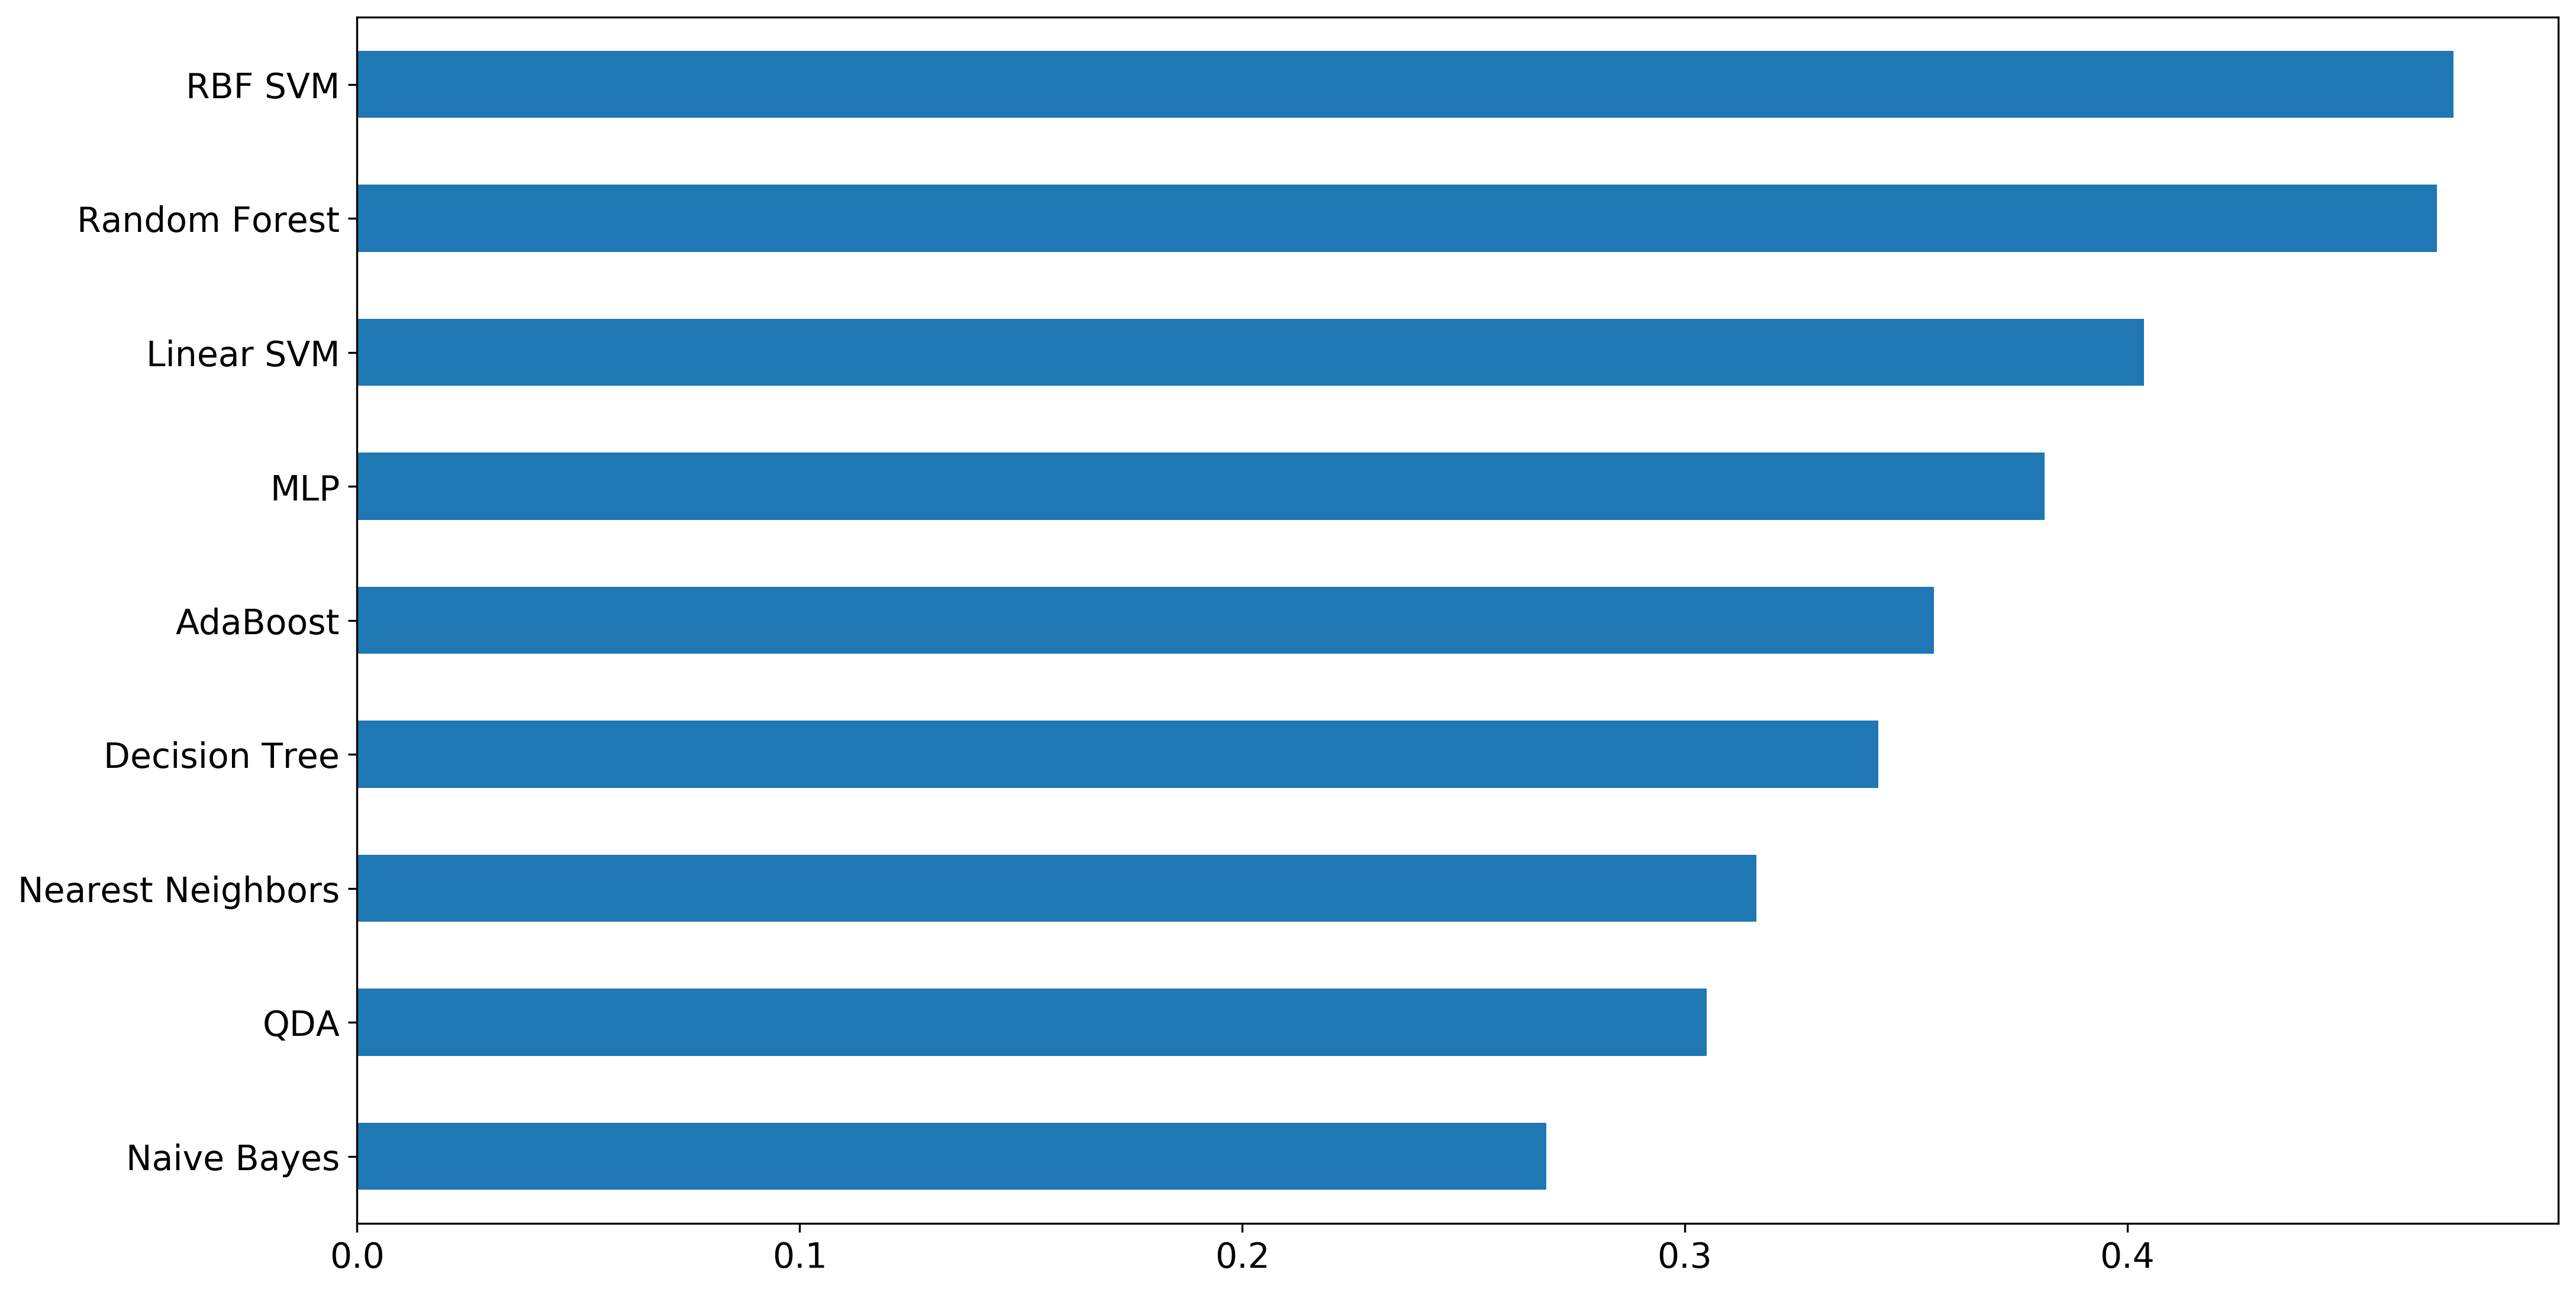

In [0]:
acc_df_all_features = pd.DataFrame()

predictions = []
accuracies = []

for name, classifier in classifiers.items():
  print(f'Training {name} Classifier')
  classifier.fit(train_features.values, train_labels.values)
  predictions.append(classifier.predict(test_features.values))
  # -1 pra pegar a última predição entre as de todos os modelos
  acc = (predictions[-1] == test_labels.values).sum() / len(predictions[-1])
  accuracies.append(acc)
  print('Acc.:', acc)

new_col = pd.Series(index=classifiers.keys(),
                    data=accuracies,
                    name='accuracy')
acc_df_all_features = acc_df_all_features.merge(new_col, right_index=True, left_index=True, how='outer')
new_col.sort_values().plot.barh()
plt.show()

                   accuracy
Nearest Neighbors   0.31625
Linear SVM          0.40375
RBF SVM             0.47375
Decision Tree       0.34375
Random Forest       0.47000
MLP                 0.38125
AdaBoost            0.35625
Naive Bayes         0.26875
QDA                 0.30500


,accuracy
Nearest Neighbors,0.31625
Linear SVM,0.40375
RBF SVM,0.47375
Decision Tree,0.34375
Random Forest,0.47000
MLP,0.38125
AdaBoost,0.35625
Naive Bayes,0.26875
QDA,0.30500


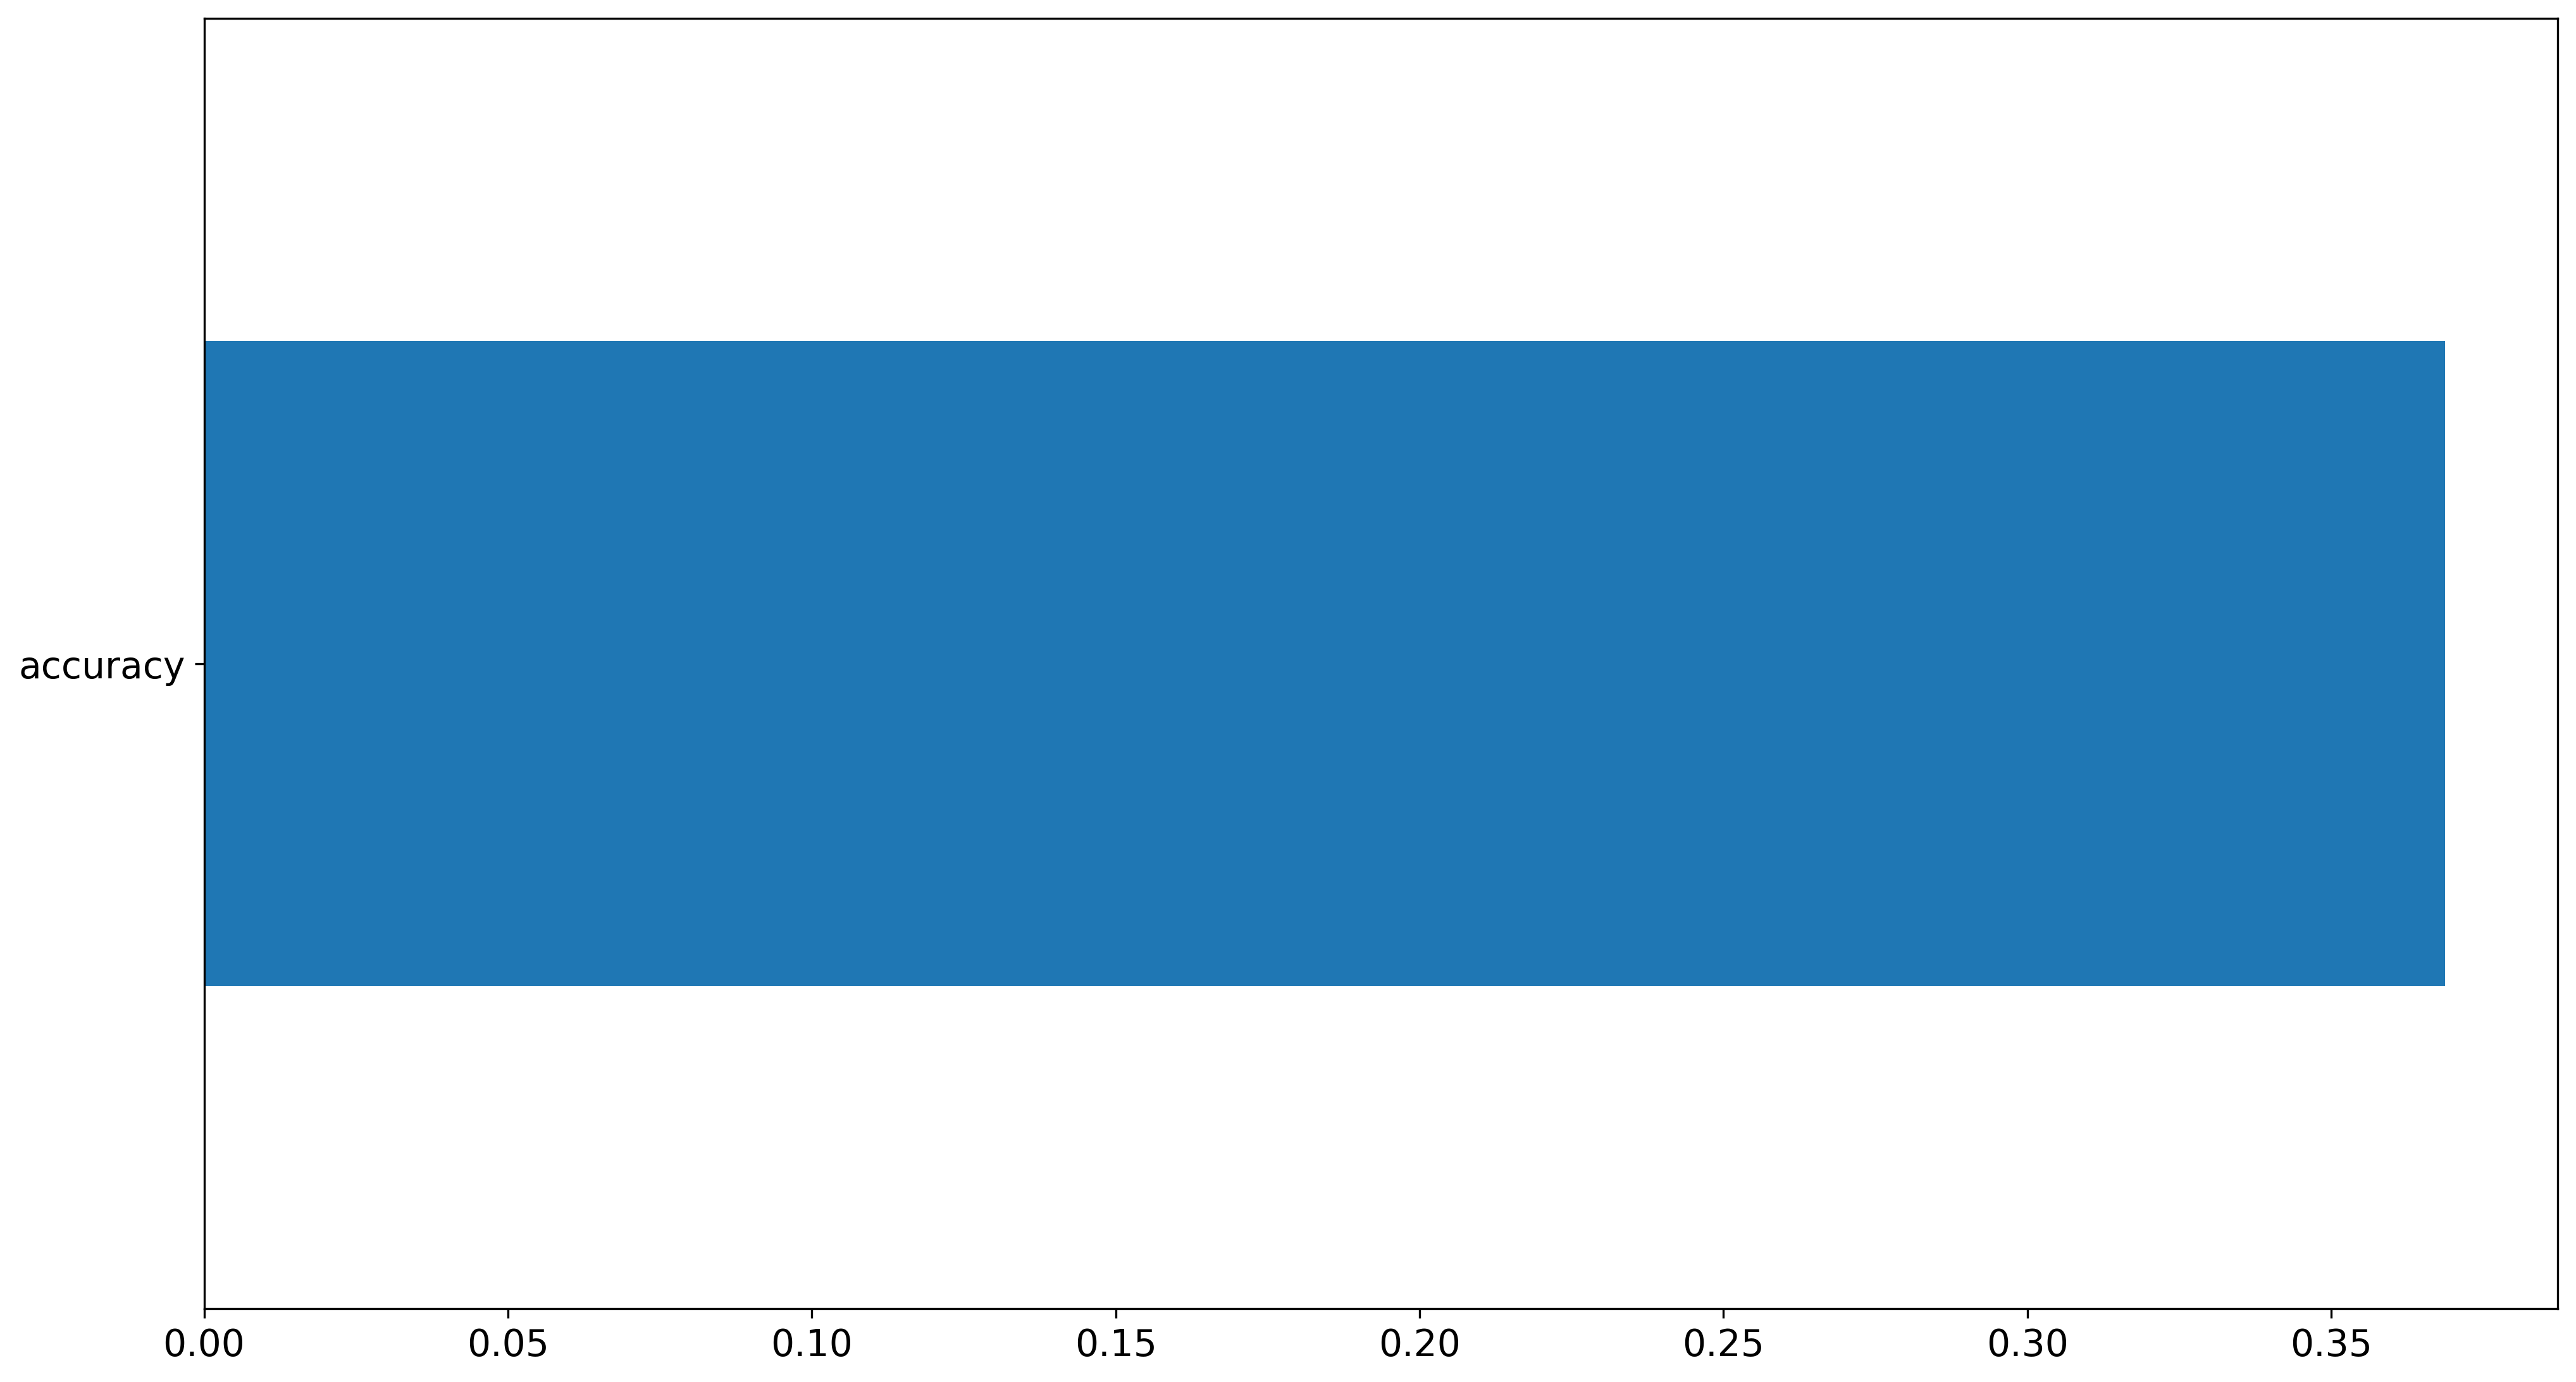

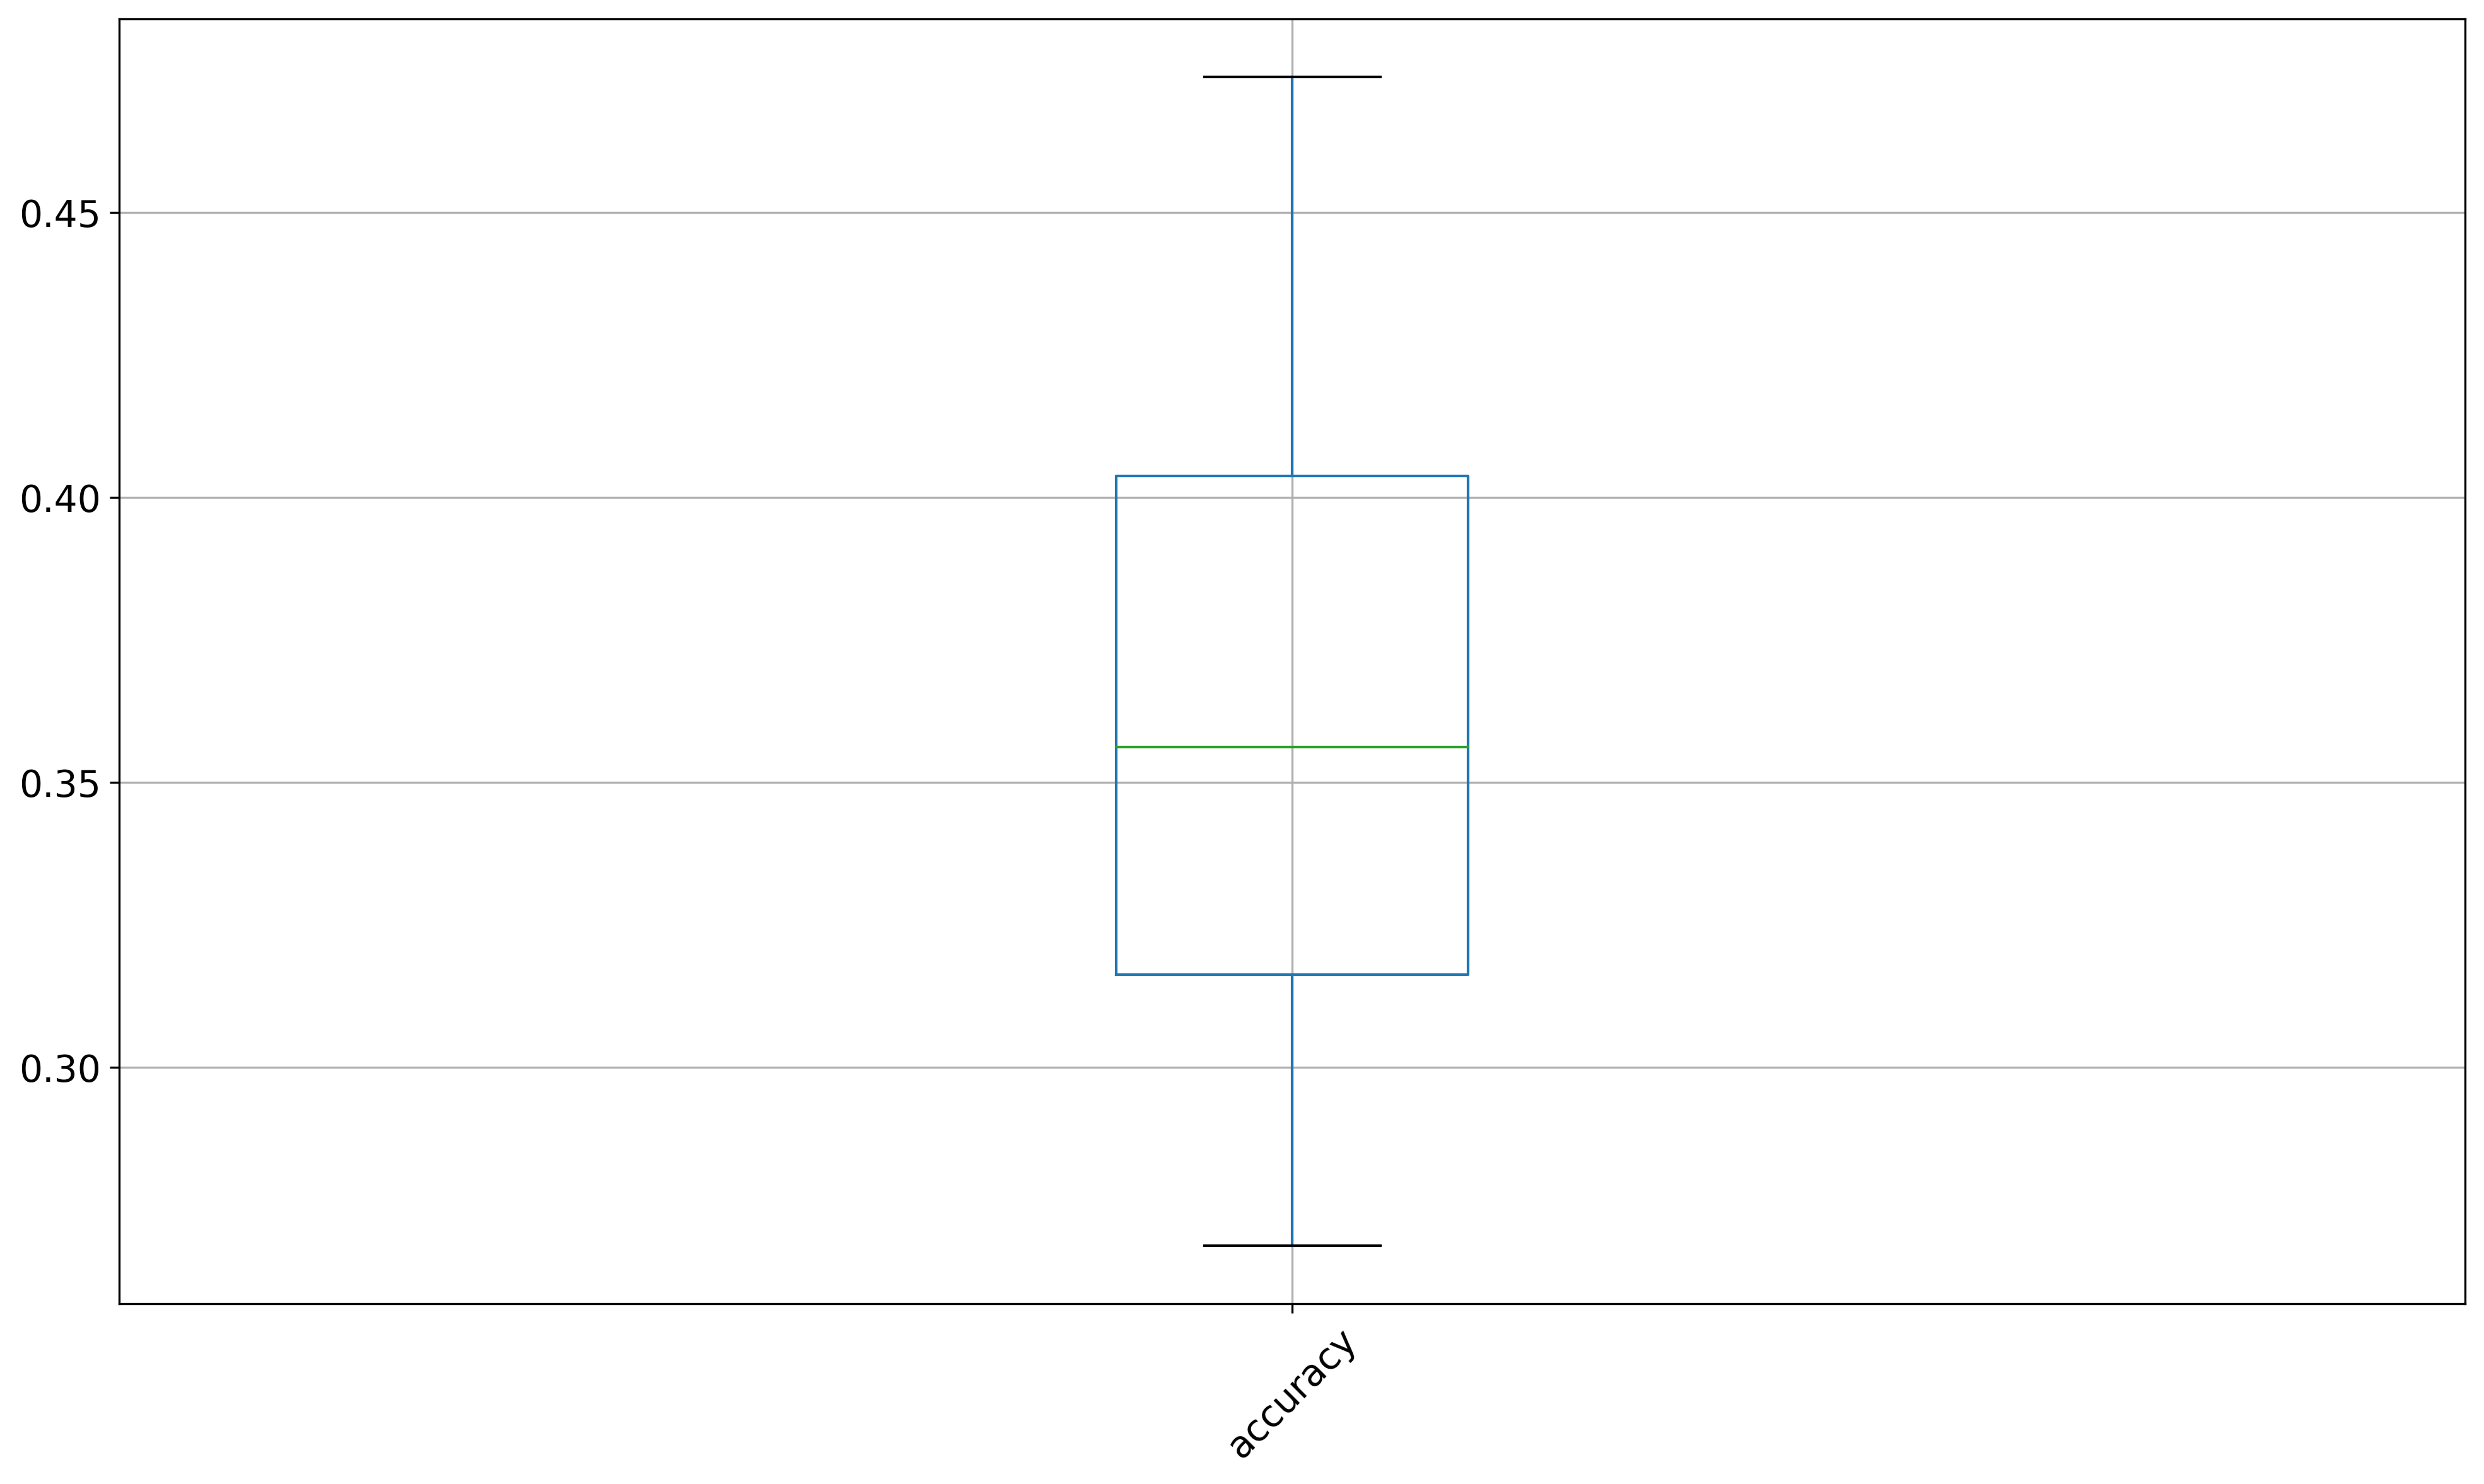

In [0]:
acc_df_all_features = acc_df_all_features[acc_df_all_features.median().sort_values(ascending=False).index]
print(acc_df_all_features)
display(acc_df_all_features)
acc_df_all_features.mean().sort_values().plot.barh()
plt.figure()
acc_df_all_features.boxplot(rot=45)

## PCA

In [0]:
from sklearn.decomposition import PCA, KernelPCA

kpca = KernelPCA(n_components=features.shape[1], kernel="rbf", fit_inverse_transform=True, n_jobs=-1)
print("Generating Kernel PCA")
X_kpca_test = kpca.fit_transform(test_features.values)
X_kpca = kpca.fit_transform(train_features.values)

print("Generating PCA")
pca = PCA()
X_pca_test = pca.fit_transform(test_features.values)
X_pca = pca.fit_transform(train_features.values)

Generating Kernel PCA
Generating PCA


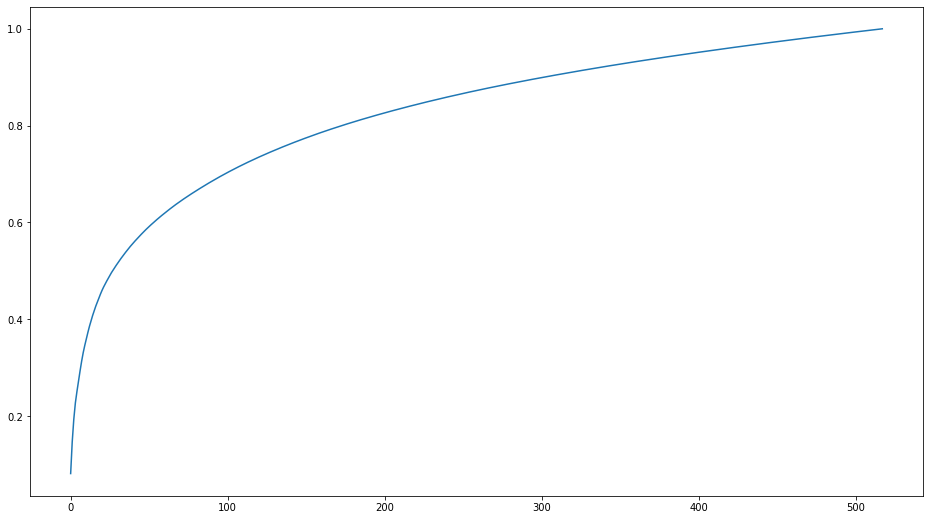

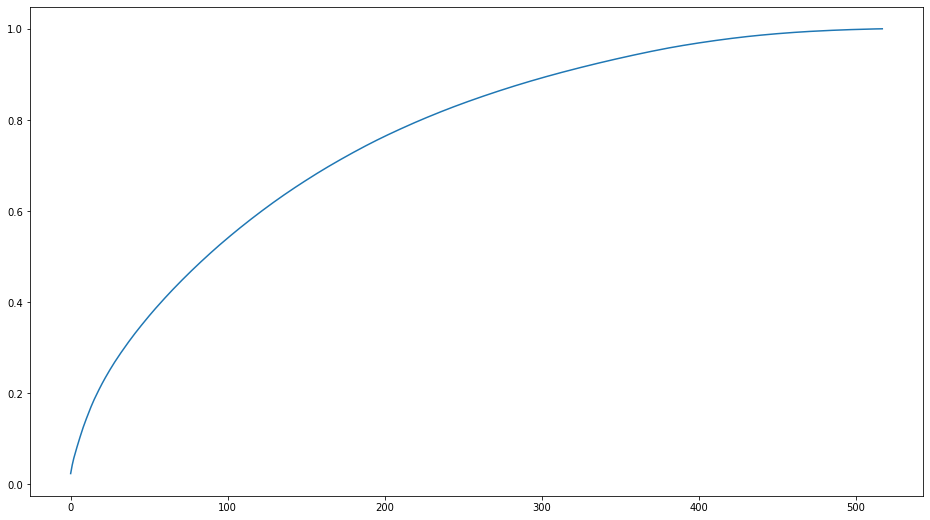

In [0]:
plt.figure(figsize=(16, 9))
plt.plot(np.cumsum(kpca.lambdas_)/np.sum(kpca.lambdas_))

plt.figure(figsize=(16, 9))
plt.plot(np.cumsum(pca.singular_values_)/np.sum(pca.singular_values_))

In [0]:
kpca_imps = np.cumsum(kpca.lambdas_/np.sum(kpca.lambdas_))
print((kpca_imps > 0.90).sum())
print((kpca_imps <= 0.90).sum())
kpca.set_params(n_components=(kpca_imps <= 0.90).sum())

pca_imps = np.cumsum(pca.singular_values_/np.sum(pca.singular_values_))
print((pca_imps > 0.90).sum())
print((pca_imps <= 0.90).sum())
pca.set_params(n_components=(pca_imps <= 0.90).sum())

216
302
209
309


PCA(copy=True, iterated_power='auto', n_components=309, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
print("Generating Kernel PCA")
X_kpca_test = kpca.fit_transform(test_features.values)
X_kpca = kpca.fit_transform(train_features.values)

print("Generating PCA")
X_pca_test = pca.fit_transform(test_features.values)
X_pca = pca.fit_transform(train_features.values)

Generating Kernel PCA
Generating PCA


## Importances

In [0]:
imp_df = pd.DataFrame([forest.feature_importances_])
imp_df.columns = features.columns

general_imps = imp_df.sum(1, level=[0]).sort_values(0, 1).unstack()
n_subcols = [general_imps[col].shape[1]
             for col in general_imps.columns.get_level_values()]
print(n_subcols)
feature_stats_imps = imp_df.sum(1, level=[0, 1]).sort_values(0, 1).unstack()
display(general_imps)
general_imps.plot.pie(figsize=(20,15))
plt.figure()
feature_stats_imps.plot.barh()
  

NameError: ignored

# Get exemplos de áudio


In [0]:
def play(name):
  try:
    if len(name) > 1:
      raise ValueError(f'name must be non-vector. name given:\n{name}')
    else:
      name=int(name[0])
  except TypeError:
    pass

  name = f'{name:0>6}'
  path = f'fma_small/{name[:3]}/{name}.mp3'
  print(name, path)
  display(Audio(path))

def maxmin_compare(*args):
  for ind in args:
    for df, m in zip((maxes, mins), ('max', 'min')):
      name = df
      print(ind, m)
      for indexador in ind:
        name = name[indexador]
      play(name)

In [0]:
maxes = features.idxmax()
mins = features.idxmin()

maxmin_compare(
  ('rmse', 'median'),
  ('rmse', 'max'),
  ('spectral_centroid', 'median'),
  ('spectral_centroid', 'std'),
  ('mfcc', 'median', '09'),
  ('mfcc', 'median', '01'),
  ('zcr', 'median'),
)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
print('Pred: Rock; label: Pop')
play(127188)
print('Pred: Electronic; label: Hip-Hop')
play(112481)
print('Pred: Instrumental; label: Experimental')
play(126507)

Output hidden; open in https://colab.research.google.com to view.